# Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
# Import Python Standard Library dependencies
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm


"""

------------------------------------------------------------

"""

import sys
import imgaug  # https://github.com/aleju/imgaug (pip3 install imgaug)

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils


/home/your_email/miniconda/envs/iptu310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

%matplotlib inline



In [3]:
from loader import CocoDataset

In [4]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cpu', torch.float32)

In [5]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [6]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrained.h5")


# Loading Dataset


In [7]:
dataset_dir = "mapping"
subset= "train"

In [8]:
dataset = CocoDataset()
coco = dataset.load_coco(dataset_dir,subset, return_coco=True)
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=29.40s)
creating index...
index created!
Image Count: 280741
Class Count: 2
  0. BG                                                
  1. building                                          


In [9]:
# Retrieve all categories from the dataset
cats = coco.loadCats(coco.getCatIds())

# Extract category names and IDs
cat_names = [cat['name'] for cat in cats]
cat_ids = [cat['id'] for cat in cats]


In [10]:
class_names = ['background']+cat_names


## Display Samples

Load and display images and masks.

In [11]:
dataset

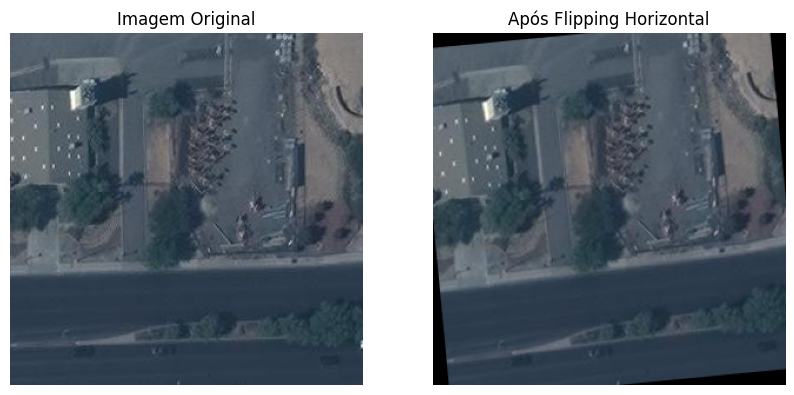

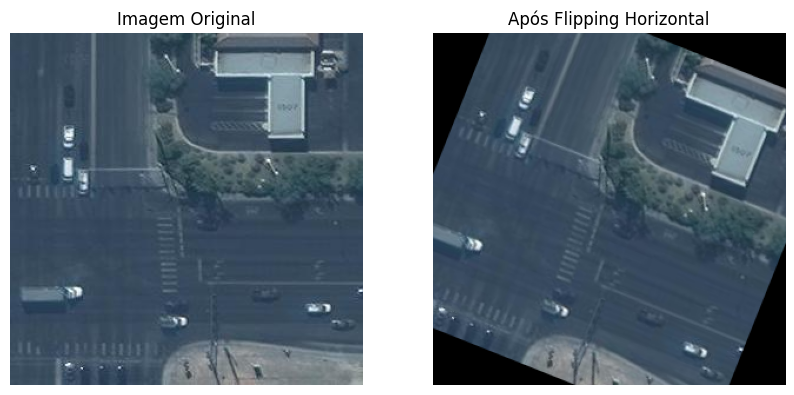

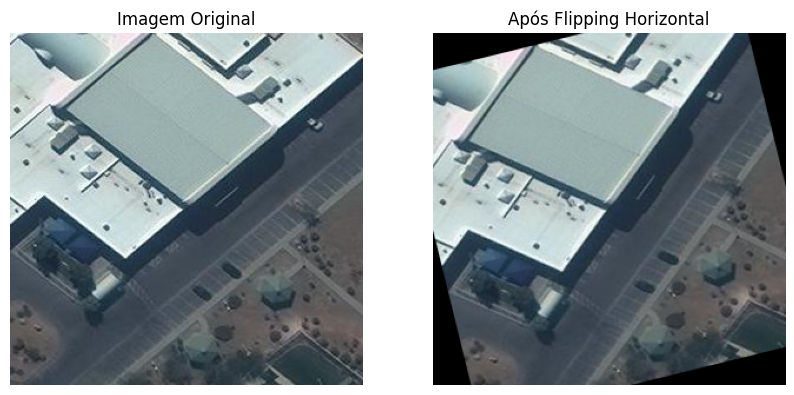

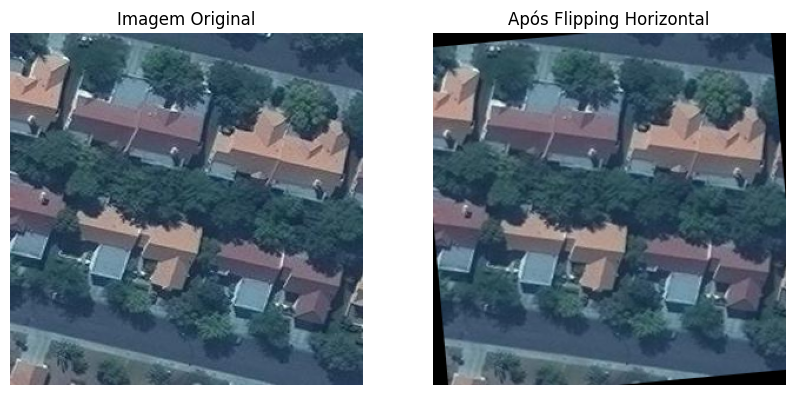

In [12]:
import imgaug.augmenters as iaa
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Supondo que `image` seja a sua imagem carregada.
# Por exemplo, vamos carregar uma imagem com OpenCV para ilustrar:
# image = cv2.imread('caminho_para_sua_imagem.jpg')

# Converte a imagem de BGR (OpenCV) para RGB (matplotlib), caso esteja usando imagens do OpenCV
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    # Define o augmenter
    # augmentation = iaa.Fliplr(1)

    # # Aplica o augmenter à imagem
    # image_aug = augmentation(image=image)
    
    augmentation = iaa.Affine(rotate=(-45, 45))  # ou iaa.Rotate((-45, 45))

    # Aplica o augmenter à imagem
    image_aug = augmentation(image=image)

    # Mostra a imagem original e a imagem após o augmentation
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image)
    axs[0].set_title('Imagem Original')
    axs[0].axis('off')

    axs[1].imshow(image_aug)
    axs[1].set_title('Após Flipping Horizontal')
    axs[1].axis('off')

    plt.show()

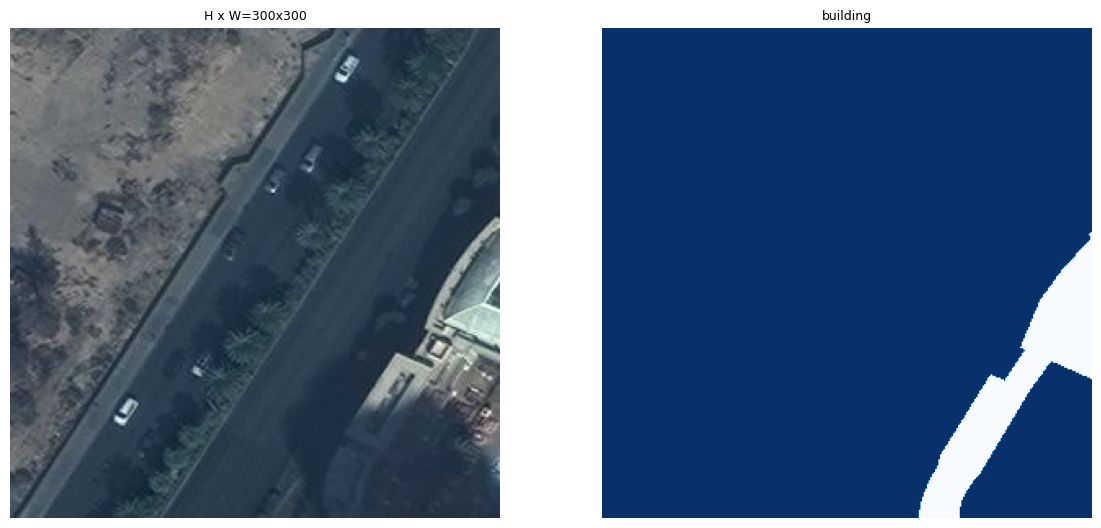

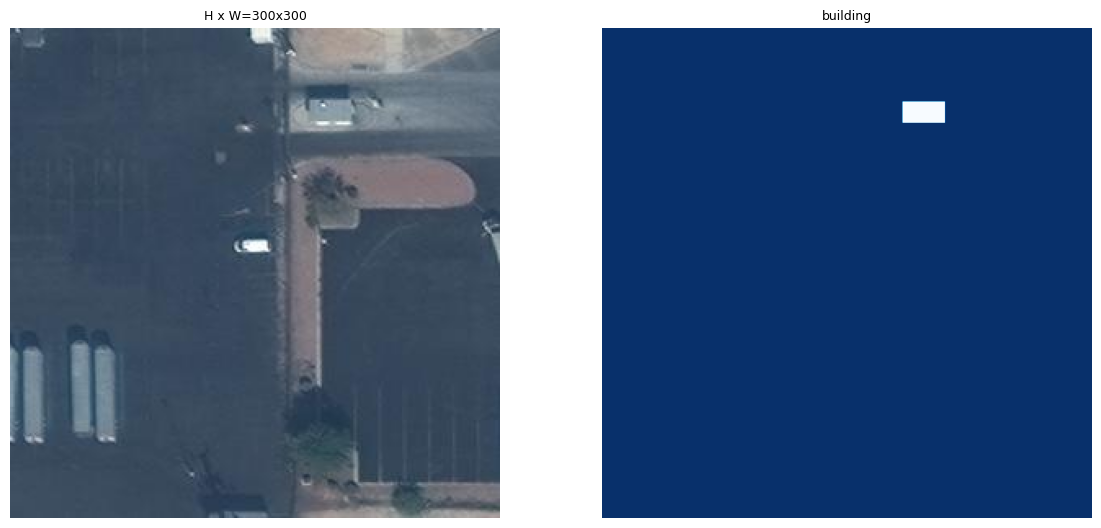

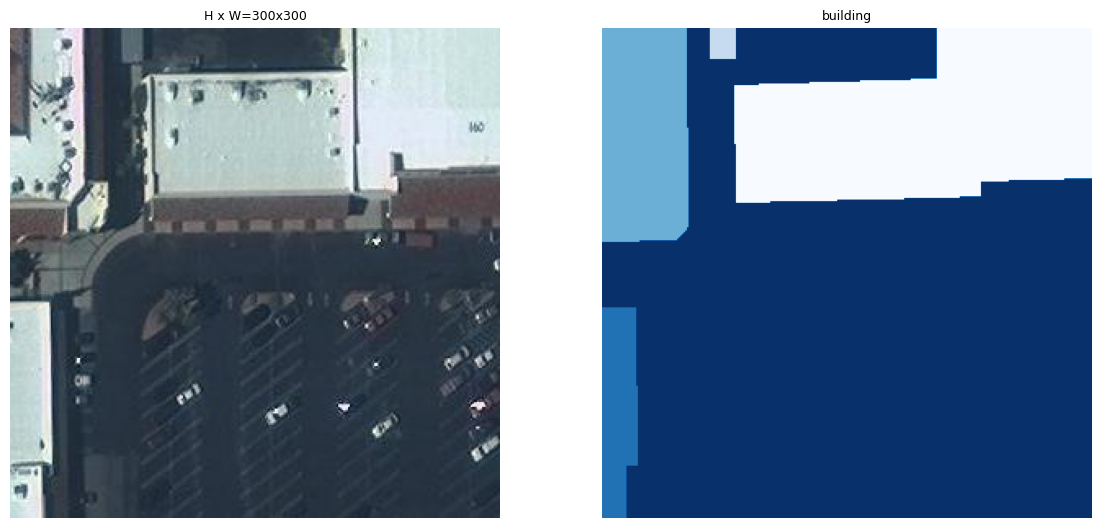

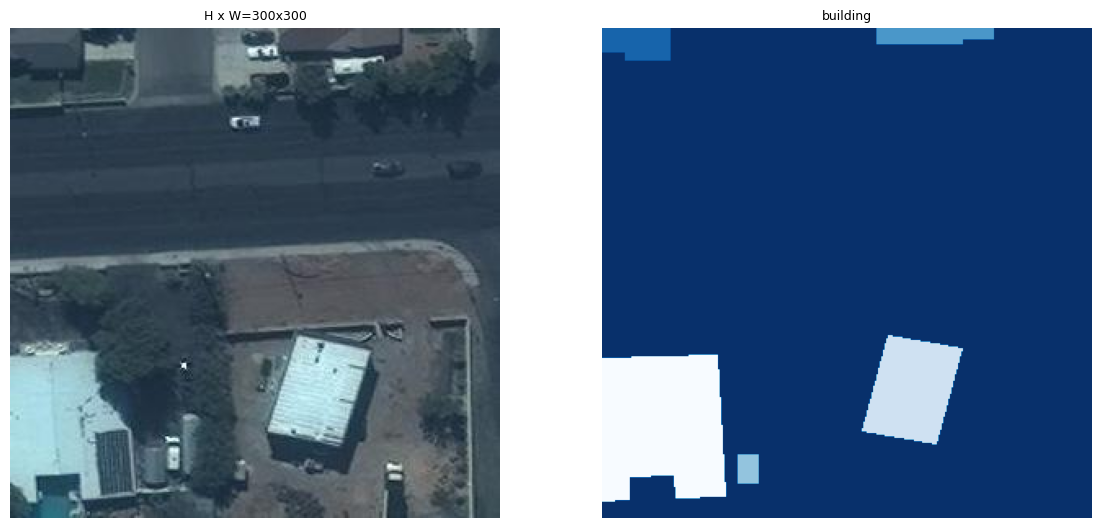

In [13]:
# Load and display random samples
import visualize
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

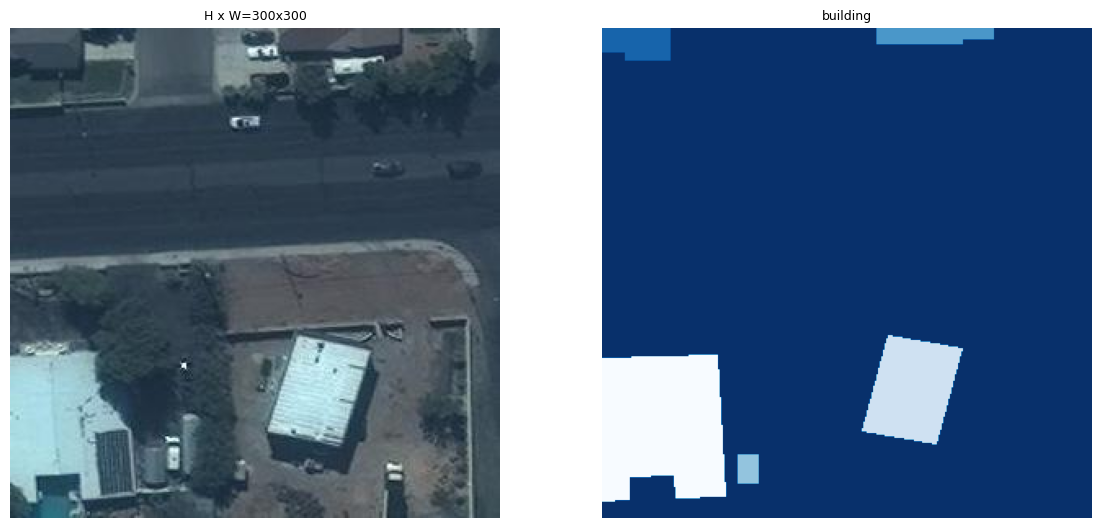

In [14]:
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)


## Loading Model

In [15]:
# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

### Summarizing the Model

In [16]:
test_inp = torch.randn(1, 3, 1024, 1024).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/home/your_email/miniconda/envs/iptu310/lib/python3.10/site-packages/torchtnt/utils/module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,MaskRCNN,45.9 M,45.7 M,183 M,331 G


# Testing Tranforming

In [17]:
from loader import CocoDataset

In [18]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

In [19]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font_size=25)

In [20]:
# Create a RandomIoUCrop object
train_sz = 300
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

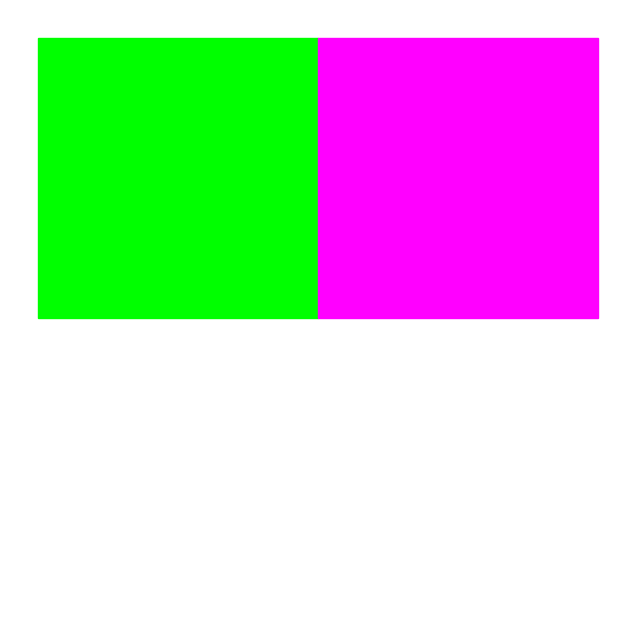

In [21]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

In [45]:
for i in range(0,70817):
    boxes = train_data[i][1]["boxes"]
    for box in boxes:
        x, y, x_max, y_max = box
        if (x_max - x) <= 0 or (y_max - y) <= 0:
            print(f"Encontrada caixa delimitadora inválida: {box}")
            print(i)
            break

Encontrada caixa delimitadora inválida: tensor([299.,  52., 299.,  52.])
0
Encontrada caixa delimitadora inválida: tensor([114.,   0., 168.,   0.])
2
Encontrada caixa delimitadora inválida: tensor([290., 299., 299., 299.])
22
Encontrada caixa delimitadora inválida: tensor([299., 102., 299., 127.])
24
Encontrada caixa delimitadora inválida: tensor([168., 299., 169., 299.])
25


ValueError: zero-size array to reduction operation minimum which has no identity

In [58]:
image, targets = train_data[22]

In [59]:
image = tensor_to_pil(image)

/home/your_email/miniconda/envs/iptu310/lib/python3.10/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


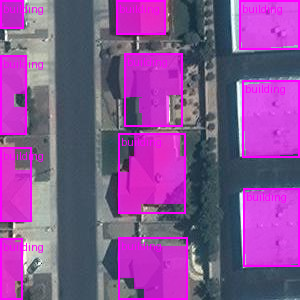

Source Image:,"(300, 300)"
Cropped Image:,"(300, 300)"
Resized Image:,"(300, 300)"
Padded Image:,"(300, 300)"
Resized Padded Image:,"(300, 300)"


In [60]:
#Extract the labels for the sample
# labels = [ i['name'] for i in coco.loadCats(coco.getCatIds()) ]
# image_id = coco.anns[313854]["image_id"]
# image_info = dataset.image_info[image_id]
# sample_img = dataset.load_image(image_id)
# sample_img = Image.fromarray(sample_img, 'RGB')
# mask1, class_ids = dataset.load_mask(image_id)
# mask1= torch.from_numpy(mask1)
# mask_tensor_bool = mask1.bool()
# mask_tensor= mask_tensor_bool.permute(2, 0, 1)

# # Generate bounding box annotations from segmentation masks
# bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(mask_tensor), format='xyxy', canvas_size=sample_img.size[::-1])

# # Get colors for dataset sample
sample_colors = [int_colors[i] for i in targets["labels"]]

# # # Prepare mask and bounding box targets
# targets = {
#     'masks': Mask(mask_tensor), 
#     'boxes': bboxes, 
#     'labels': torch.Tensor(class_ids)
# }

# # Crop the image
cropped_img, targets = iou_crop(image, targets)

# # Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# # Pad the image
padded_img, targets = pad_square(resized_img, targets)

# # Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.6, 
    colors=sample_colors
)

# # Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=sample_colors
)

# # # Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": image.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

## Preparing the Data


### Training-Validation Split

In [23]:
from dataloader import CocoDataLoader

### Image Transformations

In [24]:
# Update 'data_aug_tfms' to adjust LR flip probability
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,  # Assuming 'iou_crop' is properly defined elsewhere as a callable
        transforms.ColorJitter(
            brightness=(0.875, 1.125),
            contrast=(0.5, 1.5),
            saturation=(0.5, 1.5),
            hue=(-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.75),  # Adjusted probability to 0.75
    ],
)

# Assuming 'resize_max' and 'pad_square' are custom defined functions
# and 'train_sz' is a defined variable
resize_pad_tfm = transforms.Compose([
    resize_max,  # Custom transform func
    pad_square,  # Custom transform func
    transforms.Resize([train_sz] * 2, antialias=True),
])

# Assuming the existence of custom transform classes or functions similar to prior definitions
final_tfms = transforms.Compose([
    transforms.ToImage(),  # Assuming 'ToImage' transform exists
    transforms.ToDtype(torch.float32, scale=True),  # Assuming 'ToDtype' transform exists
    transforms.SanitizeBoundingBoxes(),  # Assuming 'SanitizeBoundingBoxes' transform exists
])

# Define the transformed training and validation datasets
train_tfms = transforms.Compose([data_aug_tfms, resize_pad_tfm, final_tfms])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Train

In [26]:
dataset = CocoDataset()
coco = dataset.load_coco(dataset_dir, 'train', return_coco=True)
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
train_data = CocoDataLoader(coco,dataset_dir,'train',dataset.class_info,)

loading annotations into memory...


Done (t=38.79s)
creating index...
index created!
Image Count: 280741
Class Count: 2
  0. BG                                                
  1. building                                          


### Val

In [25]:
dataset = CocoDataset()
coco = dataset.load_coco(dataset_dir, 'val', return_coco=True)
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
val_data = CocoDataLoader(coco,dataset_dir,'val',dataset.class_info)

loading annotations into memory...


Done (t=6.75s)
creating index...
index created!
Image Count: 60317
Class Count: 2
  0. BG                                                
  1. building                                          


### Initialize DataLoaders

In [27]:
# Set the training batch size
bs = 4

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn': lambda batch: tuple(zip(*batch)),
}
# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_data, **data_loader_params, shuffle=True)
del train_data
# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(val_data, **data_loader_params)
del val_data
# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,70186
Number of batches in validation DataLoader:,15080


## Finetuning

In [61]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    """
    Function to run a single training or evaluation epoch.
    
    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.
    
    Returns:
        The average loss for the epoch.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU disponível. Treinamento iniciará na GPU.")
    else:
        print("GPU não disponível. Treinamento não será iniciado.")
    
    # Set the model to training mode
    model.train()
    
    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar
    
    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)
        
        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))
        
            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item
        
        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    # Cleanup and close the progress bar 
    progress_bar.close()
    
    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer,  
               lr_scheduler, 
               device, 
               epochs, 
               checkpoint_path, 
               use_scaler=False):
    """
    Main training loop.
    
    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device
    
    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            model_path = f"{checkpoint_path}/model_{epoch}.pth"
            torch.save(model.state_dict(), model_path)
            wandb.log_artifact(model_path, type='model', name='best_model')
            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

## Set model checkpoint path

In [62]:
import datetime
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(f"logs/{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

logs/2024-10-22_07-55-41/maskrcnn_resnet50_fpn_v2.pth


In [63]:
# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/colormap.json")

logs/2024-10-22_07-55-41/colormap.json


### Configure the Training Parameters

In [64]:
# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 40

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

### Train Model

In [65]:
train_loop(model=model, 
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer, 
           lr_scheduler=lr_scheduler, 
           device=torch.device(device), 
           epochs=epochs, 
           checkpoint_path=checkpoint_path,
           use_scaler=True)
wandb.finish()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]


Epochs:   0%|          | 0/40 [05:18<?, ?it/s]


KeyboardInterrupt: 